In [5]:
import cv2

"""
Title: Keypoint Detection with Transfer Learning for Pole detection
Author: [Nicolas Gorlo, Tim Reinhart]
"""

"""
Based on:
Title: Keypoint Detection with Transfer Learning
Author: [Sayak Paul](https://twitter.com/RisingSayak)
Date created: 2021/05/02
Last modified: 2021/05/02
Description: Training a keypoint detector with data augmentation and transfer learning.
"""

"""
## Imports
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import getpass

In [6]:
"""
## Define hyperparameters
"""

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 600
NUM_KEYPOINTS = 7 # 7 keypoints each having x and y coordinates

In [7]:
"""
## Load data
"""

USERNAME = getpass.getuser()
IMG_DIR = "/home/" + USERNAME + "/BT_Vision/convert_to_coco/vicon_dataset_coco/images/train"
IMG_DIR_VAL = "/home/" + USERNAME + "/BT_Vision/convert_to_coco/vicon_dataset_coco/images/val"
JSON = "/home/" + USERNAME + "/BT_Vision/convert_to_coco/vicon_dataset_coco/annotations/pole_keypoints_7_train.json"
JSON_VAL = "/home/" + USERNAME + "/BT_Vision/convert_to_coco/vicon_dataset_coco/annotations/pole_keypoints_7_val.json"
KEYPOINT_DEF = (
    "keypoint_definitions.csv"
)

# Load the ground-truth annotations.
with open(JSON) as infile:
    coco_data = json.load(infile)

with open(JSON_VAL) as infile:
    coco_data_val = json.load(infile)

# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.

def coco_to_json_data(coco_data, IMG_DIR):
    coco_annotations = coco_data["annotations"]
    coco_images = coco_data["images"]
    json_data = []
    for entry in coco_annotations:
        img_bbox = entry["bbox"]
        joints = []
        for i in range(NUM_KEYPOINTS):
            joints.append([entry["keypoints"][3*i],entry["keypoints"][3*i+1],entry["keypoints"][3*i+2]])
        for img in coco_images:
            if img["id"] == entry["image_id"]:
                image_name = img["file_name"]
                image_path = os.path.join(IMG_DIR, image_name)
                img_width = img["width"]
                img_height = img["height"]
        json_data_entry = {
            "img_bbox": img_bbox,
            "img_height": img_height,
            "img_width": img_width,
            "img_path": image_path,
            "joints": joints,
        }
        json_data.append(json_data_entry)
    json_dict = {i["img_path"]: i for i in json_data}
    return json_data, json_dict


json_data, json_dict = coco_to_json_data(coco_data, IMG_DIR)
json_data_val, json_dict_val = coco_to_json_data(coco_data_val, IMG_DIR_VAL)

FileNotFoundError: [Errno 2] No such file or directory: '/home/tim/ComputerVisionBA/Code/BT_Vision/convert_to_coco/vicon_dataset_coco/annotations/pole_keypoints_7_train.json'

In [4]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex_colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()

# Utility for reading an image and for getting its annotations.

def get_pole(name):
    for i in json_dict.keys():
        if i == name:
            data = json_dict[name]
    for i in json_dict_val.keys():
        if i == name:
            data = json_dict_val[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex_colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()

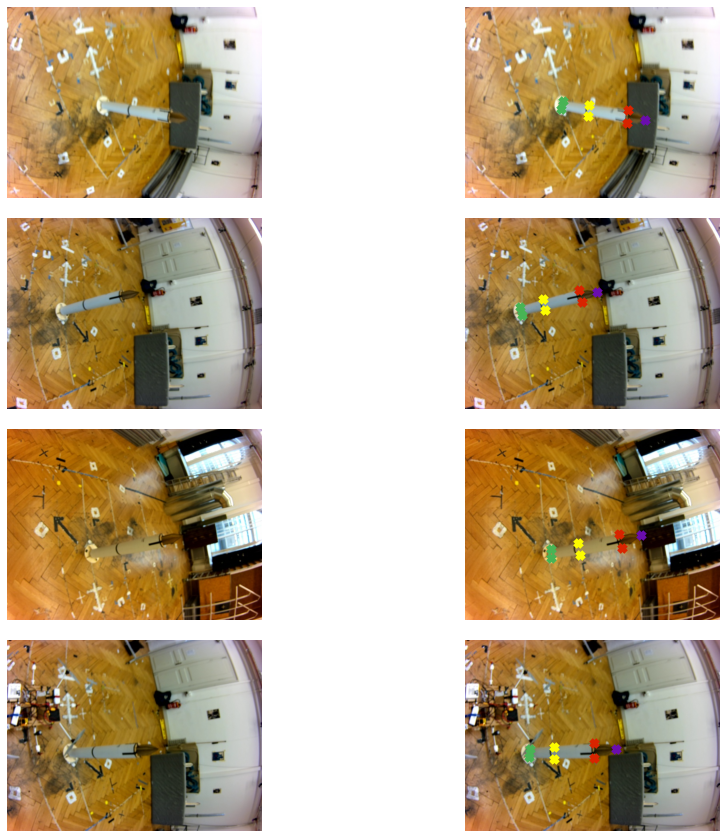

In [5]:
"""
## Visualize data
"""

# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
samples_val = list(json_dict_val.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_pole(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)


In [6]:
"""
## Prepare data generator
"""

class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS*2), dtype="float32"
        )
        for i, key in enumerate(image_keys_temp):
            data = get_pole(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[
                i,
            ] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # reshape to fit output shape of the network `(None, 1, 1, NUM_KEYPOINTS*2)`
            batch_keypoints[i,] = np.array(
                kp_temp
            ).reshape(1, 1, NUM_KEYPOINTS * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

# doc keypoints in imgaug: [this document](https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html).


In [7]:
"""
## Define augmentation transforms
"""

train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        #iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [8]:
"""
## Create training and validation splits
"""

np.random.shuffle(samples)
np.random.shuffle(samples_val)

train_keys = samples
validation_keys = samples_val

Total batches in training set: 20
Total batches in validation set: 5


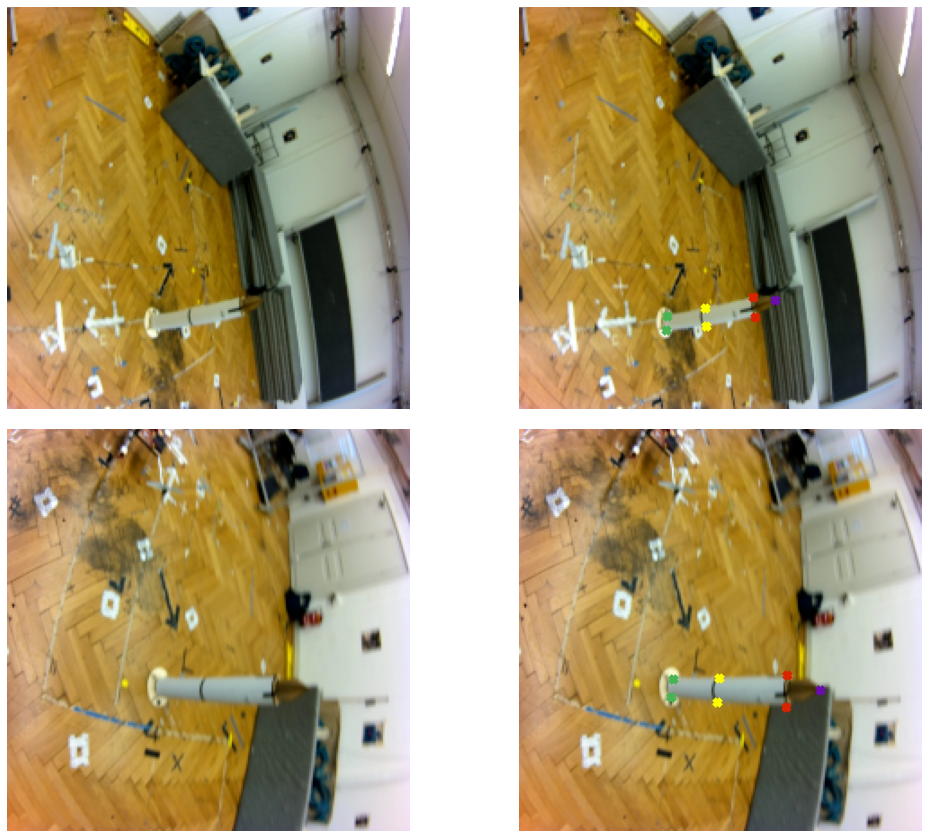

In [9]:
"""
## Data generator investigation
"""

train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() <= 1.0
assert sample_keypoints.min() >= 0.0

sample_keypoints = sample_keypoints[:2].reshape(-1, NUM_KEYPOINTS, 2) * IMG_SIZE
visualize_keypoints(sample_images[:2], sample_keypoints)

In [10]:
"""
## Model building
"""

def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS*2, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS*2, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [ ]:
"""
fully-convolutional makes it more parameter-friendly than the
same version of the network having fully-connected dense layers.
"""

get_model().summary()

In [ ]:
""""
## Model compilation and training
"""

callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0,
                patience=10,
                verbose=1,
                mode="auto",
                baseline=None,
                restore_best_weights=True,
            )

model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-3), metrics=["accuracy"])

In [ ]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, batch_size=2, callbacks=[callback])

In [ ]:
#Save Model in Network folder
model.save("network")

In [ ]:
"""
import network
"""
model = keras.models.load_model('network')

In [ ]:
"""
## Make predictions and visualize them
"""
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, NUM_KEYPOINTS, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, NUM_KEYPOINTS, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)

In [ ]:
"""
## next steps
* scale to correct output shape (640, 480)
* more "imgaug" augmentations
* Fine tune features [fine-tune](https://keras.io/guides/transfer_learning/) it. 
* adapt model (check coco keypoint detection challenge for inspirations)
"""

In [13]:
"""PNP:"""

import cv2 as cv
points_2d = predictions[0]

points_3d = np.array([
                    (0.0, 0.0, 0.0),
                    (-0.075, 0.0, -0.2),
                    (0.075, 0.0, -0.2),
                    (-0.075, 0.0, -0.7),
                    (0.075, 0.0, -0.7),
                    (-0.075, 0.0, -1.3),
                    (-0.075, 0.0, -1.3),
                    ])

camera_Matrix = np.array([(347.5293999809815 * 244/640, 0.0, 314.7548267525618 * 244/640),
                         (0.0, 347.45033648440716 * 244/480, 247.32551331252066 * 244/480),
                         (0.0, 0.0, 1.0)])

dist_coeffs = np.array([-0.06442475368146962, 0.10266027381230053, -0.16303799346444728, 0.08403964035356283])

In [14]:
success, rotation_vec, translation_vec = cv.solvePnP(points_3d, points_2d, camera_Matrix, dist_coeffs)

In [15]:
nose_end_point2d, jacobian = cv.projectPoints(np.array([(0.0,0.0,-1.0)]), rotation_vec, translation_vec, camera_Matrix, dist_coeffs)

In [ ]:
image = np.ascontiguousarray(sample_val_images[0], dtype=np.uint8)
for p in points_2d:
    cv.circle(image, (int(p[0]), int(p[1])), 3, (0,0,255) )

point1 = ( int(points_2d[0][0]), int(points_2d[0][1]) )
point2 = ( int(nose_end_point2d[0][0][0]), int(nose_end_point2d[0][0][1]) )

cv.line(image, point1, point2, (255,255,255), 2)

cv.imshow('test', image)
cv.waitKey(0)
cv.destroyAllWindows()